# March Machine Learning Mania 2025

### Forecast the 2025 NCAA Basketball Tournaments

In [ ]:
!kaggle competitions download -c march-machine-learning-mania-2025

### Versión Inicial

La estrategia que vamos a seguir, tomando como inspiración los primeros pasos del notebook de *Gleb Kazakov*, será tomar los 2 datasets con más información para entrenar el modelo, que son los que contienen los resultados de los partidos de temporada regular, y de los torneos de temporadas pasadas junto con sus estadísticas.

Los vamos a unificar añadiendo una marca, asumiendo que un partido de temporada regular y uno de torneo aportan lo mismo a las predicciones del torneo de 2025, y revisaremos que no hay duplicados. 

Y ademas crearemos un dataset agrupado por equipo (y quizas tambien por temporada) con las estadísticas resumidas.

A partir de ahí comienza nuestro desarrollo propio, estableceremos una variable objetivo en funcion a todos los enfrentamientos entre 2 equipos que hayan tenido ocasión en esa temporada, veremos si ponderamos para dar mas peso a los enfrentamientos cercanos a la fecha de comienzo del torneo, que sabemos que es sobre el día 136 de la temporada.

Y entrenaremos un modelo que prediga una variable continua, de probabilidad entre 0 y 1 estableciendo un ganador para el enfrentamiento.

In [1]:
import pandas as pd

# Read the CSV file into a dataframe
M_mncaa = pd.read_csv('..\data\MNCAATourneyDetailedResults.csv')
M_reg_season = pd.read_csv('..\data\MRegularSeasonDetailedResults.csv')
W_mncaa = pd.read_csv('..\data\WNCAATourneyDetailedResults.csv')
W_reg_season = pd.read_csv('..\data\WRegularSeasonDetailedResults.csv')
sample_submissions_1 = pd.read_csv('..\data\SampleSubmissionStage1.csv')
sample_submissions_2 = pd.read_csv('..\data\SampleSubmissionStage2.csv')
seasons = pd.read_csv('..\data\MSeasons.csv')
teams = pd.read_csv('..\data\MTeams.csv')

In [2]:
M_mncaa['mncaa'] = True
M_reg_season['mncaa'] = False
W_mncaa['mncaa'] = True
W_reg_season['mncaa'] = False

In [3]:
games = pd.concat([M_mncaa, M_reg_season, W_mncaa, W_reg_season], axis=0).reset_index(drop=True)

In [4]:
# Check for duplicates
print(games.shape)
print(games[['Season', 'DayNum', 'WTeamID', 'LTeamID']].duplicated().sum())

games.head()

(202033, 35)
0


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,mncaa
0,2003,134,1421,92,1411,84,N,1,32,69,...,14,31,17,28,16,15,5,0,22,True
1,2003,136,1112,80,1436,51,N,0,31,66,...,7,7,8,26,12,17,10,3,15,True
2,2003,136,1113,84,1272,71,N,0,31,59,...,14,21,20,22,11,12,2,5,18,True
3,2003,136,1141,79,1166,73,N,0,29,53,...,12,17,14,17,20,21,6,6,21,True
4,2003,136,1143,76,1301,74,N,1,27,64,...,15,20,10,26,16,14,5,8,19,True


In [5]:
win_features = ['WScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
lose_features = ['LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO','LStl', 'LBlk', 'LPF']

len(win_features), len(lose_features)

(14, 14)

In [6]:
# Get the features for the teams in the tournament for a range of seasons
def get_team_features(games, season_start, season_end):

    team_stats = games[games.Season.between(season_start, season_end)]
    
    win_df = team_stats[['WTeamID'] + win_features]
    win_df.columns = [col[1:] for col in win_df.columns]
    
    lose_df = team_stats[['LTeamID'] + lose_features]
    lose_df.columns = [col[1:] for col in lose_df.columns]
    
    team_stats = pd.concat([win_df, lose_df], axis=0).reset_index(drop=True)
    team_stats = team_stats.groupby('TeamID').agg('mean')

    return team_stats

# Get the features for the teams in the tournament for each season
def get_team_season_features(games):
    seasons = games['Season'].unique()
    all_seasons_stats = []

    for season in seasons:
        team_stats = games[games.Season == season]
        
        win_df = team_stats[['Season', 'WTeamID'] + win_features]
        win_df.columns = ['Season', 'TeamID'] + [col[1:] for col in win_df.columns[2:]]
        
        lose_df = team_stats[['Season', 'LTeamID'] + lose_features]
        lose_df.columns = ['Season', 'TeamID'] + [col[1:] for col in lose_df.columns[2:]]
        
        season_stats = pd.concat([win_df, lose_df], axis=0).reset_index(drop=True)
        season_stats = season_stats.groupby(['Season', 'TeamID']).agg('mean').reset_index()
        
        all_seasons_stats.append(season_stats)
    
    all_seasons_stats = pd.concat(all_seasons_stats, axis=0).reset_index(drop=True)
    return all_seasons_stats

In [7]:
team_season_stats = get_team_season_features(games)

In [8]:
print(team_season_stats.shape)

team_season_stats.head()

(13583, 16)


,Season,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000
1,2003,1103,78.777778,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852
2,2003,1104,69.034483,23.965517,57.000000,6.310345,19.586207,14.793103,20.758621,13.413793,23.793103,12.137931,13.103448,6.448276,3.862069,18.137931
3,2003,1105,71.769231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769
4,2003,1106,63.607143,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571


Vamos a definir nuevos ID y nuevos atributos en la tabla de partidos:

- ClashID : Emparejamiento entre 2 equipos en una misma temporada, puede ocurrir varias veces.
- MatchID : Clave única de partidos, concatena el ClashID con el día de la temporada, dos equipos no pueden enfrentarse dos veces un mismo día.

- Victory : 'You must predict the probability that the team with the lower TeamId beats the team with the higher TeamId'. Eso nos lleva a definir la varibable victoria como 1 si la victoria es del equipo con menor TeamID y 0 en otro caso. La usaremos para construir la variable objetivo.
- ScoreDiff : Diferencia de puntos neta entre el equipo con menor ID y mayor ID.
- TeamID_1 : El TeamID menor de los 2
- TeamID_2 : El TeamID mayor de los 2

In [9]:
games['ClashID'] = games['Season'].astype('Int64') * 100000000 + games[['WTeamID', 'LTeamID']].min(axis=1) * 10000 + games[['WTeamID', 'LTeamID']].max(axis=1)
games['MatchID'] = games['DayNum'] * 1000000000000 + games['ClashID'] 
games['Victory'] = (games[['WTeamID', 'LTeamID']].min(axis=1) == games['WTeamID']).astype(int)
games['ScoreDiff'] = games.apply(lambda row: row['WScore'] - row['LScore'] if row['WTeamID'] < row['LTeamID'] else row['LScore'] - row['WScore'], axis=1)
games['TeamID_1'] = games[['WTeamID', 'LTeamID']].min(axis=1)
games['TeamID_2'] = games[['WTeamID', 'LTeamID']].max(axis=1)

In [10]:
games.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LStl,LBlk,LPF,mncaa,ClashID,MatchID,Victory,ScoreDiff,TeamID_1,TeamID_2
0,2003,134,1421,92,1411,84,N,1,32,69,...,5,0,22,True,200314111421,134200314111421,0,-8,1411,1421
1,2003,136,1112,80,1436,51,N,0,31,66,...,10,3,15,True,200311121436,136200311121436,1,29,1112,1436
2,2003,136,1113,84,1272,71,N,0,31,59,...,2,5,18,True,200311131272,136200311131272,1,13,1113,1272
3,2003,136,1141,79,1166,73,N,0,29,53,...,6,6,21,True,200311411166,136200311411166,1,6,1141,1166
4,2003,136,1143,76,1301,74,N,1,27,64,...,5,8,19,True,200311431301,136200311431301,1,2,1143,1301


In [11]:
is_unique = games['MatchID'].is_unique
print(f"Is 'MatchID' a unique identifier? {is_unique}")

Is 'MatchID' a unique identifier? True


In [12]:
games = games.sort_values(by='ClashID', ascending=True).reset_index(drop=True)

Vamos a agrupar por ClashID, y a continuación le asociaremos a este dataset los resultados de los enfrentamientos, la diferencia de puntos, y las estadísticas de cada equipo en esa temporada, este será nuestro conjunto de entrenamiento.

In [13]:
def process_games(games):
    # Group by ClashID and Season
    grouped = games.groupby(['ClashID', 'Season', 'TeamID_1', 'TeamID_2']).agg({
        'Victory': ['count','mean'],
        'ScoreDiff': 'sum'
    }).reset_index()
    
    # Flatten the multi-level columns
    grouped.columns = ['ClashID', 'Season', 'TeamID_1', 'TeamID_2', 'Clashes', 'Victory', 'ScoreDiff']
    
    return grouped

In [14]:
clashes = process_games(games)

In [15]:
clashes.head()

,ClashID,Season,TeamID_1,TeamID_2,Clashes,Victory,ScoreDiff
0,200311021117,2003,1102,1117,1,1.0,5
1,200311021125,2003,1102,1125,1,1.0,9
2,200311021140,2003,1102,1140,2,0.0,-45
3,200311021161,2003,1102,1161,2,0.5,3
4,200311021204,2003,1102,1204,2,1.0,52


In [16]:
team_season_stats.head()

,Season,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000
1,2003,1103,78.777778,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852
2,2003,1104,69.034483,23.965517,57.000000,6.310345,19.586207,14.793103,20.758621,13.413793,23.793103,12.137931,13.103448,6.448276,3.862069,18.137931
3,2003,1105,71.769231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769
4,2003,1106,63.607143,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571


In [17]:
def join_features(target_df, features_df):
    df = (
        target_df
        .merge(features_df.add_suffix('_1'), how='left', left_on=['Season','TeamID_1'], right_on=['Season_1','TeamID_1'])
        .merge(features_df.add_suffix('_2'), how='left', left_on=['Season','TeamID_2'], right_on=['Season_2','TeamID_2'])
    )
    
    df = df.drop(columns=['Season_1', 'Season_2'])
    
    return df

In [18]:
def calculate_team_differences(df):
    # Start with key identifier columns
    key_cols = ['ID', 'ClashID', 'Season', 'TeamID_1', 'TeamID_2', 'Clashes', 'Victory', 'ScoreDiff']
    # Filter to only columns that exist in the dataframe
    existing_key_cols = [col for col in key_cols if col in df.columns]
    
    # Create output DataFrame with key columns
    result = df[existing_key_cols].copy()
    
    # Get all columns ending with '_1' except TeamID_1
    cols_1 = [col for col in df.columns if col.endswith('_1') and col != 'TeamID_1']
    
    # For each column, calculate the difference
    for col_1 in cols_1:
        # Get the base column name without the '_1' suffix
        base_col = col_1[:-2]
        # Get the corresponding '_2' column
        col_2 = base_col + '_2'
        
        # Only proceed if the corresponding '_2' column exists
        if col_2 in df.columns:
            # Calculate difference (team1 - team2)
            result[base_col + '_diff'] = df[col_1] - df[col_2]
    
    return result

In [19]:
clashes_stats_raw = join_features(clashes, team_season_stats)

In [20]:
clashes_stats_raw.head()

,ClashID,Season,TeamID_1,TeamID_2,Clashes,Victory,ScoreDiff,Score_1,FGM_1,FGA_1,...,FGA3_2,FTM_2,FTA_2,OR_2,DR_2,Ast_2,TO_2,Stl_2,Blk_2,PF_2
0,200311021117,2003,1102,1117,1,1.0,5,57.25,19.142857,39.785714,...,21.346154,15.807692,21.423077,10.961538,20.384615,11.923077,13.269231,7.153846,1.653846,21.423077
1,200311021125,2003,1102,1125,1,1.0,9,57.25,19.142857,39.785714,...,22.250000,13.285714,18.928571,10.535714,23.642857,16.892857,16.928571,9.071429,1.714286,18.357143
2,200311021140,2003,1102,1140,2,0.0,-45,57.25,19.142857,39.785714,...,16.156250,17.968750,23.812500,11.000000,24.468750,13.343750,13.656250,6.968750,2.562500,21.437500
3,200311021161,2003,1102,1161,2,0.5,3,57.25,19.142857,39.785714,...,11.548387,17.032258,24.193548,10.806452,23.483871,15.258065,16.225806,5.322581,4.225806,20.516129
4,200311021204,2003,1102,1204,2,1.0,52,57.25,19.142857,39.785714,...,17.307692,14.038462,21.884615,13.500000,22.923077,13.615385,15.807692,7.384615,3.692308,19.423077


In [21]:
clashes_stats = calculate_team_differences(clashes_stats_raw)

In [46]:
clashes_stats['Masculine'] = clashes_stats['TeamID_1'] < 2000

In [49]:
print(clashes_stats.shape)
clashes_stats.head()

(143839, 22)


,ClashID,Season,TeamID_1,TeamID_2,Clashes,Victory,ScoreDiff,Score_diff,FGM_diff,FGA_diff,...,FTM_diff,FTA_diff,OR_diff,DR_diff,Ast_diff,TO_diff,Stl_diff,Blk_diff,PF_diff,Masculine
0,200311021117,2003,1102,1117,1,1.0,5,-13.865385,-4.549451,-14.906593,...,-4.664835,-4.315934,-6.782967,-3.563187,1.076923,-1.840659,-1.189560,0.131868,-2.673077,True
1,200311021125,2003,1102,1125,1,1.0,9,-15.214286,-6.357143,-14.964286,...,-2.142857,-1.821429,-6.357143,-6.821429,-3.892857,-5.500000,-3.107143,0.071429,0.392857,True
2,200311021140,2003,1102,1140,2,0.0,-45,-14.593750,-4.763393,-11.870536,...,-6.825893,-6.705357,-6.821429,-7.647321,-0.343750,-2.227679,-1.004464,-0.776786,-2.687500,True
3,200311021161,2003,1102,1161,2,0.5,3,-16.201613,-6.986175,-12.375576,...,-5.889401,-7.086406,-6.627880,-6.662442,-2.258065,-4.797235,0.641705,-2.440092,-1.766129,True
4,200311021204,2003,1102,1204,2,1.0,52,-18.326923,-8.549451,-20.560440,...,-2.895604,-4.777473,-9.321429,-6.101648,-0.615385,-4.379121,-1.420330,-1.906593,-0.673077,True


### EDA

Dataset shape: (143839, 21)

Basic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143839 entries, 0 to 143838
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ClashID     143839 non-null  Int64  
 1   Season      143839 non-null  int64  
 2   TeamID_1    143839 non-null  int64  
 3   TeamID_2    143839 non-null  int64  
 4   Clashes     143839 non-null  int64  
 5   Victory     143839 non-null  float64
 6   ScoreDiff   143839 non-null  int64  
 7   Score_diff  143839 non-null  float64
 8   FGM_diff    143839 non-null  float64
 9   FGA_diff    143839 non-null  float64
 10  FGM3_diff   143839 non-null  float64
 11  FGA3_diff   143839 non-null  float64
 12  FTM_diff    143839 non-null  float64
 13  FTA_diff    143839 non-null  float64
 14  OR_diff     143839 non-null  float64
 15  DR_diff     143839 non-null  float64
 16  Ast_diff    143839 non-null  float64
 17  TO_diff     143839 non-null  float64
 

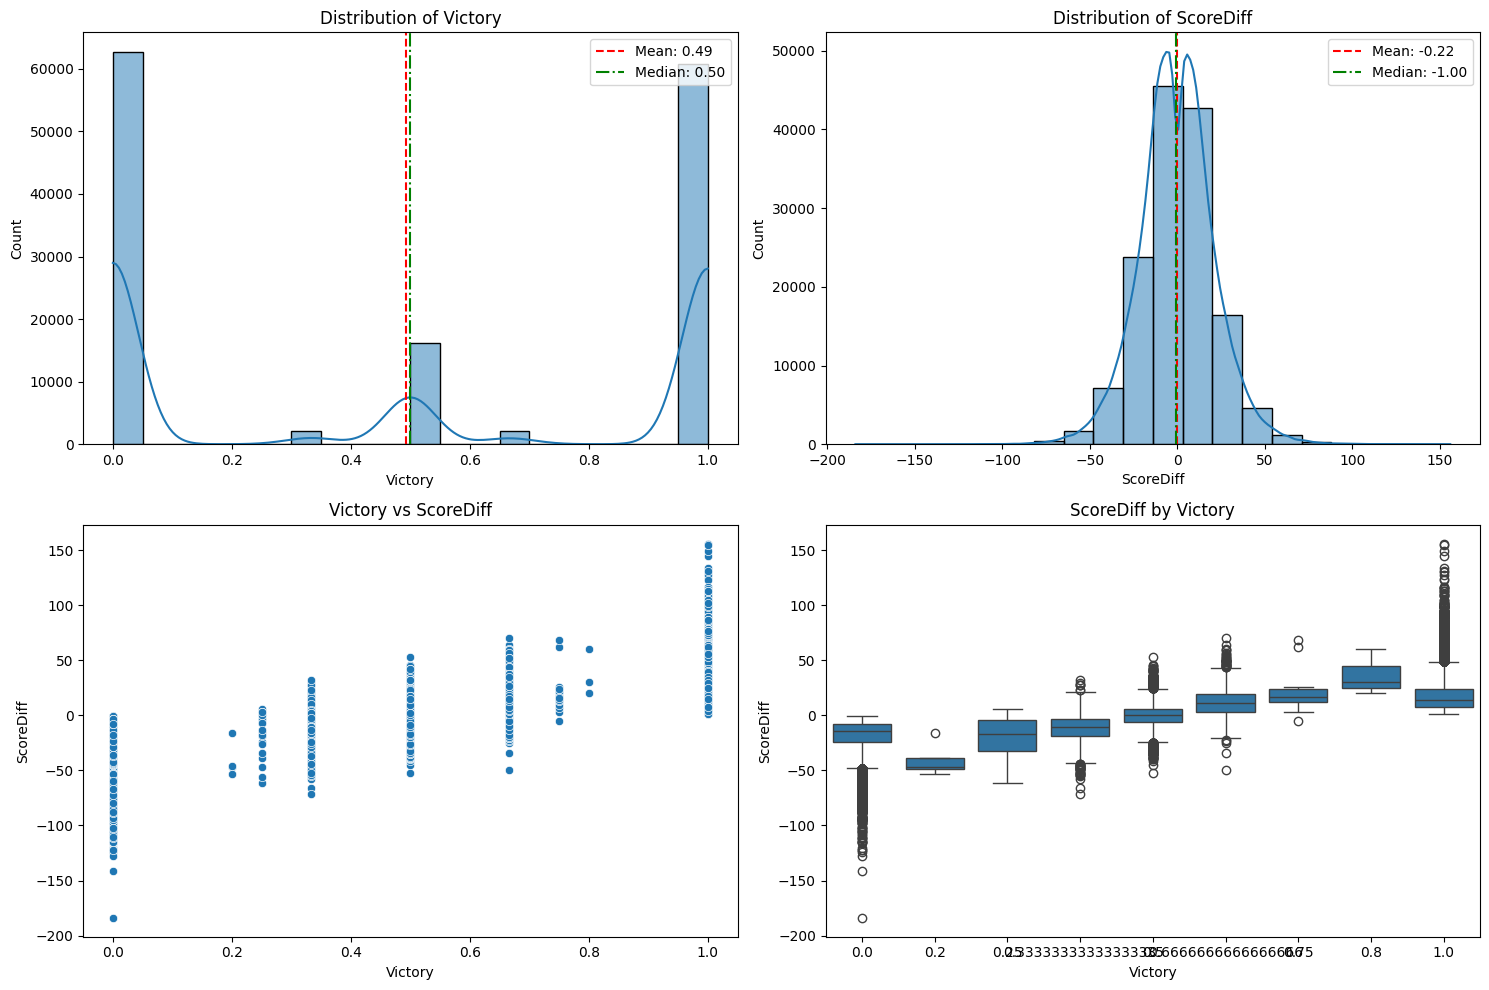

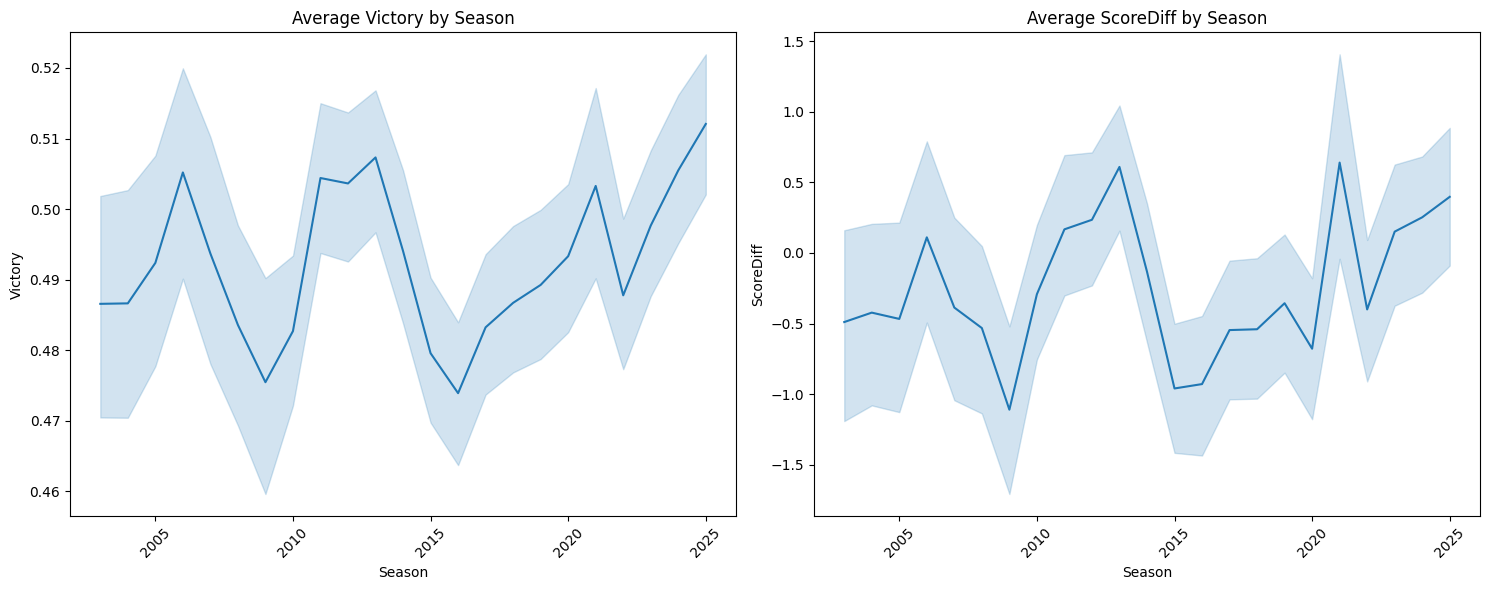

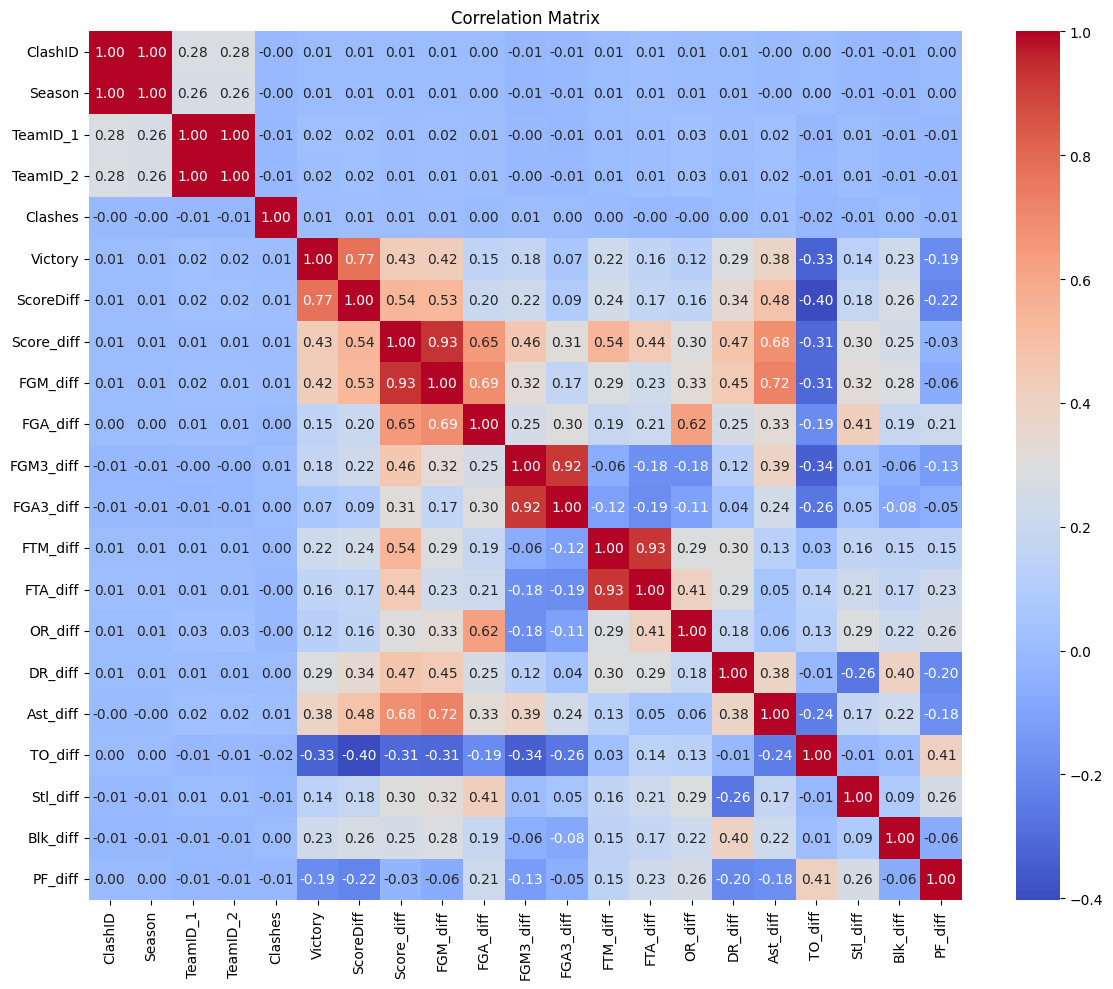


Clash analysis (top 10 most frequent):
              Victory_Mean  Victory_Std  ScoreDiff_Mean  ScoreDiff_Std  \
ClashID                                                                  
202534783479           0.5          NaN            -9.0            NaN   
200311021117           1.0          NaN             5.0            NaN   
200311021125           1.0          NaN             9.0            NaN   
200311021140           0.0          NaN           -45.0            NaN   
200311021161           0.5          NaN             3.0            NaN   
200311021204           1.0          NaN            52.0            NaN   
200311021257           0.0          NaN           -18.0            NaN   
200311021298           1.0          NaN            13.0            NaN   
200311021307           0.5          NaN            -6.0            NaN   
200311021324           0.0          NaN           -17.0            NaN   

              ScoreDiff_Min  ScoreDiff_Max  Count  
ClashID            

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Let's do a comprehensive EDA on the clashes_stats dataset
def perform_eda(df, target_cols=['Victory', 'ScoreDiff']):
    # Basic information about the dataset
    print("Dataset shape:", df.shape)
    print("\nBasic information:")
    print(df.info())
    
    print("\nDescriptive statistics:")
    print(df.describe())
    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values:")
        print(missing[missing > 0])
    else:
        print("\nNo missing values found.")
    
    # Target variables analysis
    plt.figure(figsize=(15, 10))
    
    # Distribution of Victory
    plt.subplot(2, 2, 1)
    sns.histplot(df['Victory'], kde=True, bins=20)
    plt.title('Distribution of Victory')
    plt.axvline(df['Victory'].mean(), color='r', linestyle='--', label=f"Mean: {df['Victory'].mean():.2f}")
    plt.axvline(df['Victory'].median(), color='g', linestyle='-.', label=f"Median: {df['Victory'].median():.2f}")
    plt.legend()
    
    # Distribution of ScoreDiff
    plt.subplot(2, 2, 2)
    sns.histplot(df['ScoreDiff'], kde=True, bins=20)
    plt.title('Distribution of ScoreDiff')
    plt.axvline(df['ScoreDiff'].mean(), color='r', linestyle='--', label=f"Mean: {df['ScoreDiff'].mean():.2f}")
    plt.axvline(df['ScoreDiff'].median(), color='g', linestyle='-.', label=f"Median: {df['ScoreDiff'].median():.2f}")
    plt.legend()
    
    # Relationship between Victory and ScoreDiff
    plt.subplot(2, 2, 3)
    sns.scatterplot(x='Victory', y='ScoreDiff', data=df)
    plt.title('Victory vs ScoreDiff')
    
    # Box plot of ScoreDiff by Victory categories
    plt.subplot(2, 2, 4)
    if df['Victory'].nunique() <= 10:  # Only if Victory has a reasonable number of categories
        sns.boxplot(x='Victory', y='ScoreDiff', data=df)
        plt.title('ScoreDiff by Victory')
    
    plt.tight_layout()
    plt.show()
    
    # Seasonality analysis
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Season', y='Victory', data=df, estimator='mean', errorbar=('ci', 95))
    plt.title('Average Victory by Season')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Season', y='ScoreDiff', data=df, estimator='mean', errorbar=('ci', 95))
    plt.title('Average ScoreDiff by Season')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis
    # Only include numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_cols].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()
    
    # Analysis by ClashID
    clash_stats = df.groupby('ClashID').agg({
        'Victory': ['mean', 'std'],
        'ScoreDiff': ['mean', 'std', 'min', 'max'],
        'Season': 'count'
    })
    
    clash_stats.columns = ['Victory_Mean', 'Victory_Std', 'ScoreDiff_Mean', 
                           'ScoreDiff_Std', 'ScoreDiff_Min', 'ScoreDiff_Max', 'Count']
    
    print("\nClash analysis (top 10 most frequent):")
    print(clash_stats.sort_values('Count', ascending=False).head(10))
    
    # Additional insights
    if 'TeamID_1' in df.columns and 'TeamID_2' in df.columns:
        # Team performance analysis
        team1_stats = df.groupby('TeamID_1').agg({
            'Victory': 'mean',
            'ScoreDiff': 'mean'
        }).rename(columns={'Victory': 'Team1_Victory_Rate', 'ScoreDiff': 'Team1_Avg_ScoreDiff'})
        
        team2_stats = df.groupby('TeamID_2').agg({
            'Victory': 'mean',
            'ScoreDiff': 'mean'
        }).rename(columns={'Victory': 'Team2_Victory_Rate', 'ScoreDiff': 'Team2_Avg_ScoreDiff'})
        
        print("\nTop 5 teams as Team1:")
        print(team1_stats.sort_values('Team1_Victory_Rate', ascending=False).head())
        
        print("\nTop 5 teams as Team2:")
        print(team2_stats.sort_values('Team2_Victory_Rate', ascending=True).head())  # Lower is better for Team2

    return

# Run the EDA
perform_eda(clashes_stats)

### Train the model

Training set: 100687 samples
Validation set: 21576 samples
Test set: 21576 samples

Training Linear Regression...
  Training RMSE: 14.9265
  Validation RMSE: 14.9891
  Validation R^2: 0.5109
  Validation MAE: 11.6671

Training Ridge Regression...
  Training RMSE: 14.9265
  Validation RMSE: 14.9891
  Validation R^2: 0.5109
  Validation MAE: 11.6671

Training Lasso Regression...
  Training RMSE: 14.9449
  Validation RMSE: 15.0153
  Validation R^2: 0.5092
  Validation MAE: 11.6713

Training Random Forest...
  Training RMSE: 5.6295
  Validation RMSE: 15.0871
  Validation R^2: 0.5044
  Validation MAE: 11.7509

Training Gradient Boosting...
  Training RMSE: 14.9494
  Validation RMSE: 15.1926
  Validation R^2: 0.4975
  Validation MAE: 11.7713

Training XGBoost...
  Training RMSE: 13.0527
  Validation RMSE: 14.7719
  Validation R^2: 0.5249
  Validation MAE: 11.5264

Best model: XGBoost
Validation RMSE: 14.7719
Validation R^2: 0.5249


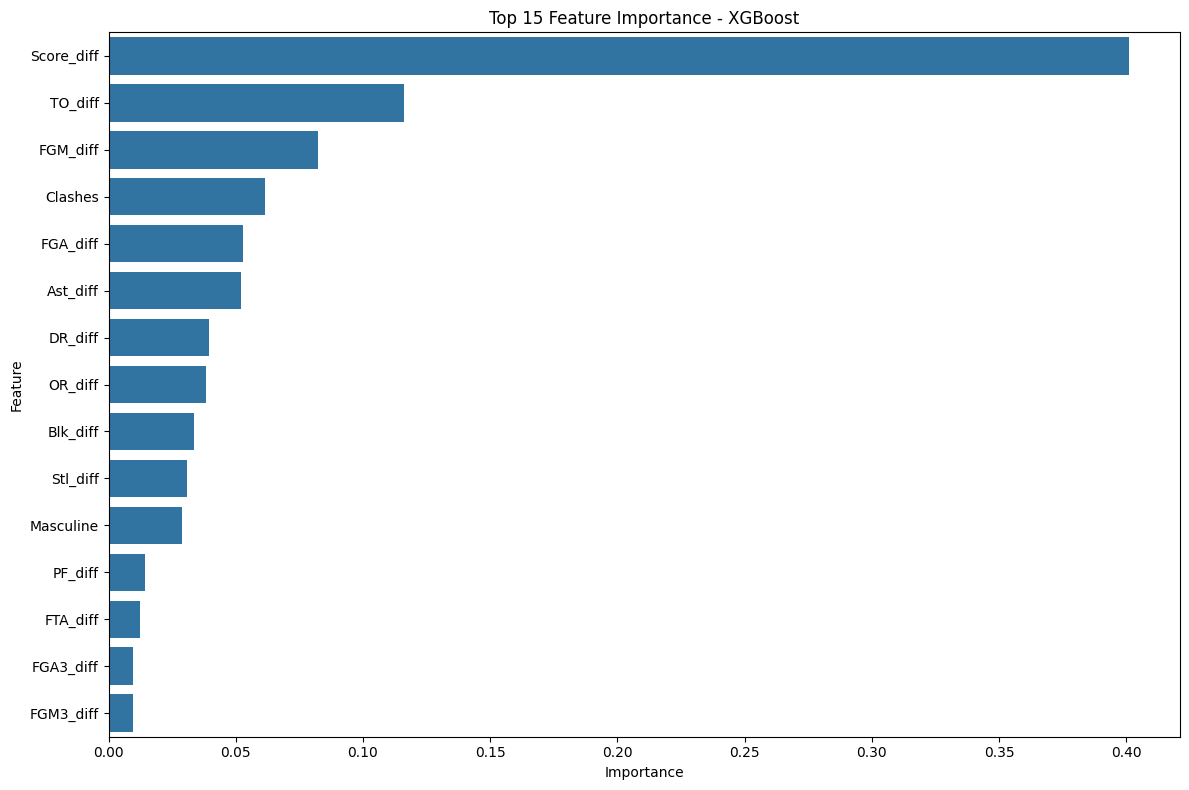


Top 10 most important features:
       Feature  Importance
2   Score_diff    0.401101
12     TO_diff    0.116229
3     FGM_diff    0.082273
1      Clashes    0.061629
4     FGA_diff    0.052701
11    Ast_diff    0.051997
10     DR_diff    0.039539
9      OR_diff    0.038256
14    Blk_diff    0.033747
13    Stl_diff    0.030996

Test set evaluation for XGBoost:
Test RMSE: 14.7264
Test R^2: 0.5299
Test MAE: 11.5280


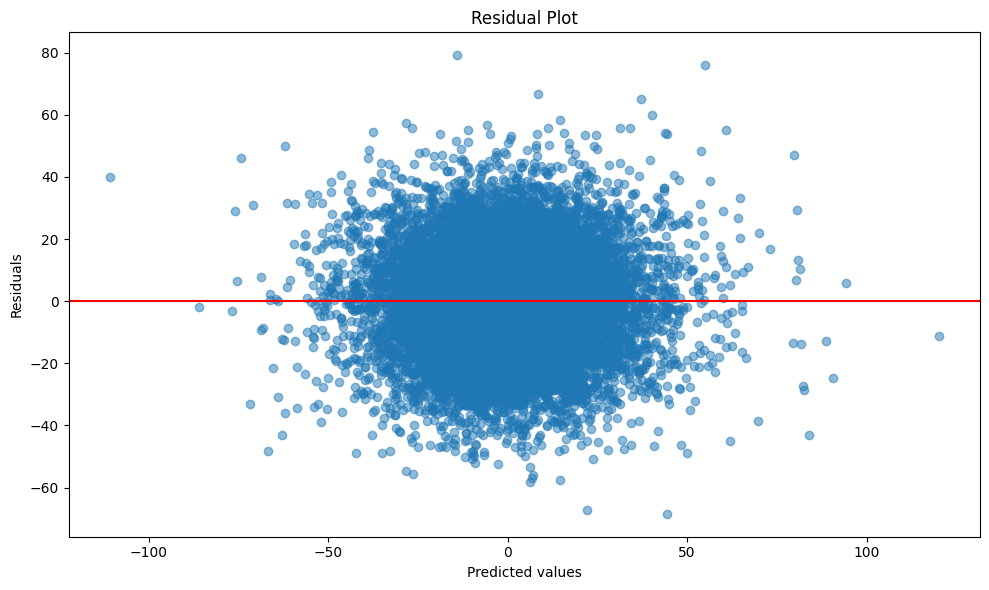

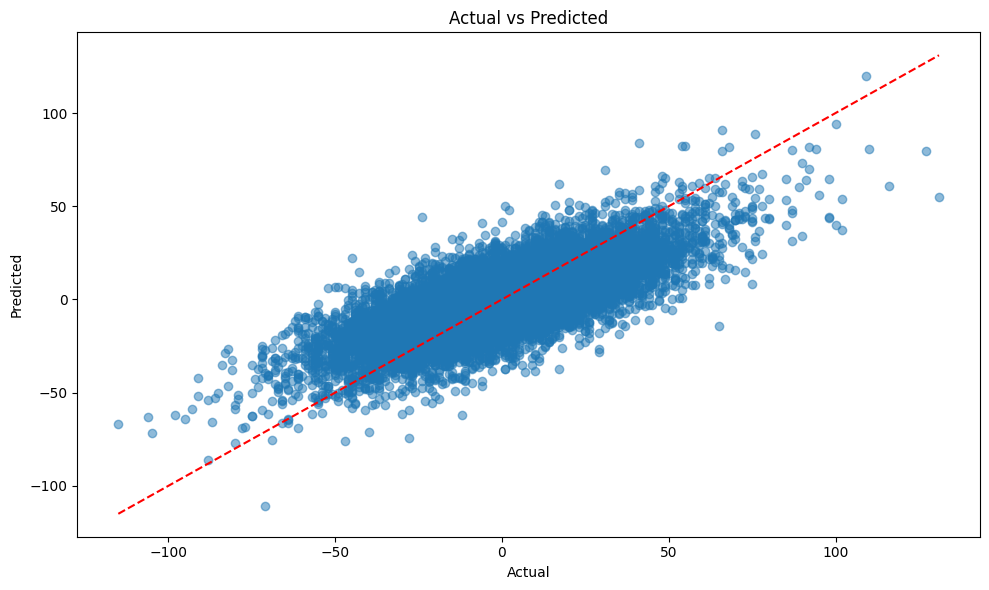

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.pipeline import Pipeline

def build_scorediff_model(df):
    # Make a copy of the dataframe to avoid modifying the original
    data = df.copy()
    
    # Define features and target variable
    # Exclude non-feature columns and the target itself
    exclude_cols = ['ID', 'ClashID', 'TeamID_1', 'TeamID_2', 'ScoreDiff', 'Victory']
    features = [col for col in data.columns if col not in exclude_cols]
    
    # Use ScoreDiff as our target
    X = data[features]
    y = data['ScoreDiff']
    
    # Split into training (70%), validation (15%), and test (15%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=43)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=43)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Create a preprocessing pipeline
    preprocessing = StandardScaler()
    
    # Train multiple models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
    }
    
    # Dictionary to store results
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Scale features
        X_train_scaled = preprocessing.fit_transform(X_train)
        X_val_scaled = preprocessing.transform(X_val)
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        train_preds = model.predict(X_train_scaled)
        val_preds = model.predict(X_val_scaled)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        val_r2 = r2_score(y_val, val_preds)
        val_mae = mean_absolute_error(y_val, val_preds)
        
        print(f"  Training RMSE: {train_rmse:.4f}")
        print(f"  Validation RMSE: {val_rmse:.4f}")
        print(f"  Validation R^2: {val_r2:.4f}")
        print(f"  Validation MAE: {val_mae:.4f}")
        
        # Store results
        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'val_mae': val_mae,
            'preprocessing': preprocessing
        }
    
    # Find the best model based on validation RMSE
    best_model_name = min(results, key=lambda x: results[x]['val_rmse'])
    best_model_info = results[best_model_name]
    
    print(f"\nBest model: {best_model_name}")
    print(f"Validation RMSE: {best_model_info['val_rmse']:.4f}")
    print(f"Validation R^2: {best_model_info['val_r2']:.4f}")
    
    # Get feature importance for the best model (if available)
    if hasattr(best_model_info['model'], 'feature_importances_'):
        feature_importance = best_model_info['model'].feature_importances_
        feature_names = X_train.columns
        
        # Create a dataframe for feature importance
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'Top 15 Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most important features:")
        print(importance_df.head(10))
    
    # Evaluate best model on test set
    best_model = best_model_info['model']
    X_test_scaled = best_model_info['preprocessing'].transform(X_test)
    test_preds = best_model.predict(X_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_r2 = r2_score(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    
    print(f"\nTest set evaluation for {best_model_name}:")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R^2: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    # Residual plot
    plt.figure(figsize=(10, 6))
    residuals = y_test - test_preds
    plt.scatter(test_preds, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()
    plt.show()
    
    # Actual vs Predicted plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.tight_layout()
    plt.show()
    
    return best_model_info

# Run the model building function
best_model_info = build_scorediff_model(clashes_stats)

Vemos que la regresión lineal funciona muy bien. Entrenamos el modelo con ella.

In [27]:
# Make a copy of the dataframe to avoid modifying the original
data = clashes_stats.copy()

# Define features and target variable
# Exclude non-feature columns and the target itself
exclude_cols = ['ID', 'ClashID', 'TeamID_1', 'TeamID_2', 'ScoreDiff', 'Victory']
features = [col for col in data.columns if col not in exclude_cols]

# Use ScoreDiff as our target
X_train = data[features]
y_train = data['ScoreDiff']

preprocessing = StandardScaler()
model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Scale features
X_train_scaled = preprocessing.fit_transform(X_train)

# Train model
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)

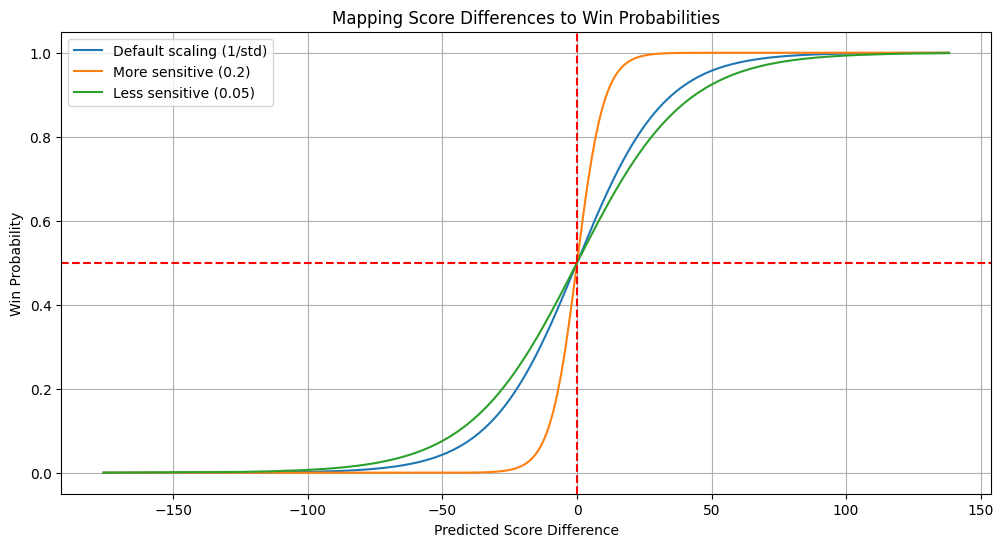

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def score_diff_to_probability(y_pred, scaling_factor=None):
    if scaling_factor is None:
        # Calculate scaling factor based on data distribution
        # Dividing by standard deviation gives reasonable spread
        scaling_factor = 1 / np.std(y_pred)
    
    # Apply sigmoid function: 1 / (1 + exp(-scaled_y_pred))
    probabilities = 1 / (1 + np.exp(-scaling_factor * y_pred))
    
    return probabilities

# Convert predictions to probabilities
# Try different scaling factors to find the right sensitivity
probabilities_default = score_diff_to_probability(y_train_pred)
probabilities_more_sensitive = score_diff_to_probability(y_train_pred, scaling_factor=0.2)
probabilities_less_sensitive = score_diff_to_probability(y_train_pred, scaling_factor=0.05)

# Visualize the transformation
plt.figure(figsize=(12, 6))

# Sort for better visualization
sorted_indices = np.argsort(y_train_pred)
sorted_preds = np.array(y_train_pred)[sorted_indices]
sorted_probs_default = probabilities_default[sorted_indices]
sorted_probs_more = probabilities_more_sensitive[sorted_indices]
sorted_probs_less = probabilities_less_sensitive[sorted_indices]

# Plot different scaling options
plt.plot(sorted_preds, sorted_probs_default, label='Default scaling (1/std)')
plt.plot(sorted_preds, sorted_probs_more, label='More sensitive (0.2)')
plt.plot(sorted_preds, sorted_probs_less, label='Less sensitive (0.05)')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Predicted Score Difference')
plt.ylabel('Win Probability')
plt.title('Mapping Score Differences to Win Probabilities')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
y_train_prob = score_diff_to_probability(y_train_pred)

In [31]:
y_train_prob

array([0.52681434, 0.73021835, 0.1733964 , ..., 0.74615693, 0.70619696,
       0.52389216], shape=(143839,), dtype=float32)

### Submit Submissions

In [32]:
sample_submissions_2.head()

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5


In [33]:
clashes_target = sample_submissions_2.copy()

clashes_target[['Season', 'TeamID_1', 'TeamID_2']] = clashes_target['ID'].str.split('_', expand=True)
clashes_target['Season'] = clashes_target['Season'].astype(int)
clashes_target['TeamID_1'] = clashes_target['TeamID_1'].astype(int)
clashes_target['TeamID_2'] = clashes_target['TeamID_2'].astype(int)
clashes_target['Clashes'] = 1
clashes_target['ClashID'] = (clashes_target['Season'].astype(str) + clashes_target['TeamID_1'].astype(str) + clashes_target['TeamID_2'].astype(str)).astype(int)
clashes_target = clashes_target.drop(columns=['Pred'])

In [34]:
clashes_target.head()

,ID,Season,TeamID_1,TeamID_2,Clashes,ClashID
0,2025_1101_1102,2025,1101,1102,1,202511011102
1,2025_1101_1103,2025,1101,1103,1,202511011103
2,2025_1101_1104,2025,1101,1104,1,202511011104
3,2025_1101_1105,2025,1101,1105,1,202511011105
4,2025_1101_1106,2025,1101,1106,1,202511011106


In [35]:
clashes_target_raw = join_features(clashes_target, team_season_stats)

Tratamiento de nulos, en vez de estadísticas de esa temporada, usamos sus estadísticas entre 2022 y 2025 (con ese rango se resuelve) para esos enfrentamientos.

In [36]:
# Get team stats from 2022-2025
historical_team_stats = get_team_features(games, 2022, 2025)
# Check which rows have any null values
is_row_to_fill = clashes_target_raw.isnull().any(axis=1)
rows_to_fill = clashes_target_raw.loc[is_row_to_fill]
# Replace null values with historical team stats
rows_to_fill = rows_to_fill[['ID', 'Season', 'TeamID_1', 'TeamID_2', 'Clashes', 'ClashID']].drop_duplicates()
rows_to_fill = rows_to_fill.merge(historical_team_stats.add_suffix('_1'), how='left', left_on='TeamID_1', right_on='TeamID')
rows_to_fill = rows_to_fill.merge(historical_team_stats.add_suffix('_2'), how='left', left_on='TeamID_2', right_on='TeamID')

clashes_target_raw = pd.concat([clashes_target_raw[~is_row_to_fill], rows_to_fill], ignore_index=True)
clashes_target_raw = clashes_target_raw.sort_values(by='ClashID', ascending=True).reset_index(drop=True)

In [37]:
clashes_target_stats = calculate_team_differences(clashes_target_raw)

In [48]:
clashes_target_stats['Masculine'] = clashes_target_stats['TeamID_1'] < 2000

In [38]:
clashes_target_stats.head()

,ID,ClashID,Season,TeamID_1,TeamID_2,Clashes,Score_diff,FGM_diff,FGA_diff,FGM3_diff,FGA3_diff,FTM_diff,FTA_diff,OR_diff,DR_diff,Ast_diff,TO_diff,Stl_diff,Blk_diff,PF_diff
0,2025_1101_1102,202511011102,2025,1101,1102,1,4.928205,2.566667,4.400000,-3.874359,-9.774359,3.669231,3.084615,2.269231,-1.500000,-1.102564,1.751282,4.515385,-0.169231,2.917949
1,2025_1101_1103,202511011103,2025,1101,1103,1,-15.645604,-6.035714,-9.178571,-6.379121,-15.057692,2.804945,4.706044,-1.516484,-5.857143,-5.626374,1.527473,2.758242,-0.947802,2.206044
2,2025_1101_1104,202511011104,2025,1101,1104,1,-23.538462,-6.793103,-8.758621,-6.359416,-15.876658,-3.592838,-4.822281,-3.041114,-8.948276,-4.562334,1.436340,4.046419,-1.889920,1.953581
3,2025_1101_1105,202511011105,2025,1101,1105,1,-3.538462,0.307692,-5.769231,-3.423077,-10.961538,-0.730769,-2.692308,-3.423077,-0.807692,-0.192308,-1.423077,1.884615,-1.038462,-0.961538
4,2025_1101_1106,202511011106,2025,1101,1106,1,-5.717033,-1.428571,-7.892857,-4.629121,-12.950549,1.769231,2.063187,-0.802198,-2.750000,1.159341,5.241758,2.758242,-0.197802,2.170330


In [39]:
clashes_stats.head()

,ClashID,Season,TeamID_1,TeamID_2,Clashes,Victory,ScoreDiff,Score_diff,FGM_diff,FGA_diff,...,FGA3_diff,FTM_diff,FTA_diff,OR_diff,DR_diff,Ast_diff,TO_diff,Stl_diff,Blk_diff,PF_diff
0,200311021117,2003,1102,1117,1,1.0,5,-13.865385,-4.549451,-14.906593,...,-0.524725,-4.664835,-4.315934,-6.782967,-3.563187,1.076923,-1.840659,-1.189560,0.131868,-2.673077
1,200311021125,2003,1102,1125,1,1.0,9,-15.214286,-6.357143,-14.964286,...,-1.428571,-2.142857,-1.821429,-6.357143,-6.821429,-3.892857,-5.500000,-3.107143,0.071429,0.392857
2,200311021140,2003,1102,1140,2,0.0,-45,-14.593750,-4.763393,-11.870536,...,4.665179,-6.825893,-6.705357,-6.821429,-7.647321,-0.343750,-2.227679,-1.004464,-0.776786,-2.687500
3,200311021161,2003,1102,1161,2,0.5,3,-16.201613,-6.986175,-12.375576,...,9.273041,-5.889401,-7.086406,-6.627880,-6.662442,-2.258065,-4.797235,0.641705,-2.440092,-1.766129
4,200311021204,2003,1102,1204,2,1.0,52,-18.326923,-8.549451,-20.560440,...,3.513736,-2.895604,-4.777473,-9.321429,-6.101648,-0.615385,-4.379121,-1.420330,-1.906593,-0.673077


In [42]:
# Make a copy of the dataframe to avoid modifying the original
data = clashes_target_stats.copy()

# Define features and target variable
# Exclude non-feature columns and the target itself
exclude_cols = ['ID', 'ClashID', 'TeamID_1', 'TeamID_2', 'ScoreDiff', 'Victory']
features = [col for col in data.columns if col not in exclude_cols]

# Use ScoreDiff as our target
X = data[features]

preprocessing = StandardScaler()

# Scale features
X_scaled = preprocessing.fit_transform(X)

y_pred = model.predict(X_scaled)

y_prob = score_diff_to_probability(y_pred)

In [44]:
submission_1 = clashes_target_stats['ID'].to_frame()
submission_1['Pred'] = y_prob
submission_1.head()

,ID,Pred
0,2025_1101_1102,0.577562
1,2025_1101_1103,0.370826
2,2025_1101_1104,0.145995
3,2025_1101_1105,0.668863
4,2025_1101_1106,0.415184


In [45]:
submission_1.to_csv('../output/submission_3.csv', index=False)